# Canny y umbralización - Equipo 512 - M.P.I - 19/10/2023

### Integrantes:
- Carapia Barcena Mauricio Javier.
- Landeros Castellanos Jared Noe.
- Martínez Arroyo Edgar Rodrigo.
- Peña Bravo María Cecilia.
- Romero Olaéz Gustavo.

## Importaciones

In [21]:
#Importación de la biblioteca OpenCV (cv2) para el visionado.
import cv2

#Importación de la biblioteca NumPy para el manejo eficiente de matrices y arreglos.
import numpy as np

#Importación de la biblioteca matplotlib.pyplot para la visualización de gráficos y figuras.
from matplotlib import pyplot as plt

## Declaraciones

In [22]:
# Declaración de un objeto VideoCapture para abrir el archivo de video.
video1 = cv2.VideoCapture('./video/desplazamiento.mp4')
video2 = cv2.VideoCapture('./video/rebote.mp4')
video3 = cv2.VideoCapture('./video/desplazamientoRuido.mp4')
video4 = cv2.VideoCapture('./video/reboteRuido.mp4')

# Listas vacías para almacenar todos los cuadros.
framesDesplazamiento = []
framesDesplazamientoRuido = []
framesRebote = []
framesReboteRuido = []

# Muestras.
muestraDesplazamiento = ['./cuadrosDesplazamiento/frame49.jpg',
            './cuadrosDesplazamiento/frame53.jpg',
            './cuadrosDesplazamiento/frame55.jpg',
            './cuadrosDesplazamiento/frame60.jpg',
            './cuadrosDesplazamiento/frame65.jpg']

muestraDesplazamientoRuido = [
    './cuadrosDesplazamientoRuido/frame45.jpg', 
    './cuadrosDesplazamientoRuido/frame58.jpg', 
    './cuadrosDesplazamientoRuido/frame63.jpg',
    './cuadrosDesplazamientoRuido/frame70.jpg',
    './cuadrosDesplazamientoRuido/frame73.jpg'
]

muestraRebote = [
    './cuadrosRebote/frame56.jpg',
    './cuadrosRebote/frame59.jpg',
    './cuadrosRebote/frame61.jpg',
    './cuadrosRebote/frame63.jpg',
    './cuadrosRebote/frame69.jpg',
    './cuadrosRebote/frame71.jpg',
    './cuadrosRebote/frame89.jpg',
    './cuadrosRebote/frame109.jpg',
    './cuadrosRebote/frame134.jpg'
]

muestraReboteRuido = [
    './cuadrosReboteRuido/frame37.jpg',
    './cuadrosReboteRuido/frame40.jpg',
    './cuadrosReboteRuido/frame52.jpg',
    './cuadrosReboteRuido/frame67.jpg',
    './cuadrosReboteRuido/frame68.jpg'
]

# Gráficas de resultados de todos los cuadros.
graficasCanny = [
    './centroides/canny/gráficaCanny_Desplazamiento.png',
    './centroides/canny/gráficaCanny_DesplazamientoRuido.png',
    './centroides/canny/gráficaCanny_Rebote.png',
    './centroides/canny/gráficaCanny_ReboteRuido.png'
]

graficasUmbral = [
    './centroides/umbral/gráficaUmbral_Desplazamiento.png',
    './centroides/umbral/gráficaUmbral_DesplazamientoRuido.png',
    './centroides/umbral/gráficaUmbral_Rebote.png',
    './centroides/umbral/gráficaUmbral_ReboteRuido.png'
]

## Guardado de imágenes

In [23]:
def visualizarGuardarImg(imagen, nombre, arreglo, imprimir=True):
    if imprimir:
        plt.imshow(imagen)
        # Pausa brevemente la ejecución para permitir que la imagen se muestre en la ventana de Matplotlib.
        plt.pause(0.03)
    
    # Guarda la imagen en el disco con el nombre especificado y vuelve a convertir los colores para respetar la tonalidad original.
    imagen = cv2.convertScaleAbs(imagen)
    cv2.imwrite(nombre, cv2.cvtColor(imagen, cv2.COLOR_RGB2BGR))
    arreglo.append(nombre)

## Obtención de cuadros

In [24]:
def obtenerCuadros(video, arregloParaAlmacenarImg, cuadros=10, rutaNombre =  './cuadrosDesplazamiento/frame', imprimir = True):
    cont = 0
    while True: #Lee los cuadros dentro del ciclo.
        ret, cuadro = video.read()
        
         #Verifica si la lectura del cuadro fue exitosa (ret es True) o si se ha llegado al final del video (ret es False).
        if not ret:
            break
        
        cuadroRGB = cv2.cvtColor(cuadro, cv2.COLOR_BGR2RGB)
        cont += 1

        nombre = f'{rutaNombre}{cont}.jpg'
        
        visualizarGuardarImg(cuadroRGB, nombre, arregloParaAlmacenarImg, imprimir)

        if cuadros is not None and cont >= cuadros:
            break
        
    #Deja de usar el recurso.
    video.release() 
    plt.close('all')

### Implementación:

In [25]:
obtenerCuadros(video1, framesDesplazamiento, None, imprimir = False)
obtenerCuadros(video2, framesRebote, None, './cuadrosRebote/frame', False)
obtenerCuadros(video3, framesDesplazamientoRuido, None, './cuadrosDesplazamientoRuido/frame', False)
obtenerCuadros(video4, framesReboteRuido, None, './cuadrosReboteRuido/frame', False)

## Pruebas en una muestra reducida

## Método 1 - Detección de bordes con Canny

In [26]:
def contornearGraficarPorCanny(ruta_imagenes, imprimir = True, nombreGrafica=""):
    centroides_x = []
    centroides_y = []

    for ruta_imagen in ruta_imagenes:
        imagen = cv2.imread(ruta_imagen)

        # 0. Extraer el canal azul de la imagen original y quitar el fondo de la foto con un operador binario (suma).
        canal_azul = imagen[:, :, 0]  # El canal azul se encuentra en el primer canal (índice 0).
        imagen_azul = np.zeros_like(imagen)
        imagen_azul[:, :, 0] = canal_azul  # Colocar el canal azul en el canal azul de la nueva imagen.

        imagen_sumada = cv2.add(imagen_azul, imagen_azul) # Para aislar el fondo/quitarlo sin binarizar/umbralizar.

        # 1. Convertir la imagen original a escala de grises.
        imagen_gris = cv2.cvtColor(imagen_sumada, cv2.COLOR_BGR2GRAY)

        # 2. Aplicar algún filtro para mejorar la segmentación.
        imagen_filtrada = cv2.GaussianBlur(imagen_gris, (5, 5), 0)

        # 3. Aplicar Canny.
        bordes = cv2.Canny(imagen_filtrada, 0, 10)

        # 4. Obtener contornos y centroides de Canny.
        contornos, _ = cv2.findContours(bordes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        imagen_contornos = imagen.copy()
        cv2.drawContours(imagen_contornos, contornos, -1, (0, 0, 255), 5) # Rojo.
    
        for contorno in contornos:
            momentos = cv2.moments(contorno)
            if momentos["m00"] != 0:
                centroide_x = int(momentos["m10"] / momentos["m00"])
                centroide_y = int(momentos["m01"] / momentos["m00"])
                centroides_x.append(centroide_x)
                centroides_y.append(centroide_y)
                cv2.circle(imagen_contornos, (centroide_x, centroide_y), 5, (0, 0, 0), -1)  # Puntos conectados (centroides) en color negro.

        imagen_rgb = cv2.cvtColor(imagen_contornos, cv2.COLOR_BGR2RGB)

        # Mostrar la imagen original, la imagen azul, la imagen sumada, el filtro Gaussiano, el filtro Canny y los contornos en subplots.
        if imprimir:
            fig, axes = plt.subplots(1, 6, figsize=(24, 6))

            axes[0].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB), cmap='gray')
            axes[0].set_title('Imagen original')
            axes[0].axis('off')

            axes[1].imshow(cv2.cvtColor(imagen_azul, cv2.COLOR_BGR2RGB), cmap='gray')
            axes[1].set_title('Imagen azul')
            axes[1].axis('off')

            axes[2].imshow(cv2.cvtColor(imagen_sumada, cv2.COLOR_BGR2RGB), cmap='gray')
            axes[2].set_title('Imagen sumada')
            axes[2].axis('off')

            axes[3].imshow(imagen_filtrada, cmap='gray')
            axes[3].set_title('Grises y filtro Gaussiano')
            axes[3].axis('off')

            axes[4].imshow(bordes, cmap='gray')
            axes[4].set_title('Filtro Canny')
            axes[4].axis('off')

            axes[5].imshow(imagen_rgb)
            axes[5].set_title('Imagen con contornos')
            axes[5].axis('off')

            plt.show()

    # Crear una gráfica para mostrar todos los centroides de todas las imágenes juntas.
    plt.scatter(centroides_x, centroides_y, c='r', marker='o', label='Centroides')
    plt.title('Centroides')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True)
    
    if imprimir == False :
        plt.savefig(f'./centroides/canny/gráficaCanny_{nombreGrafica}.png')
        plt.close() 
    elif imprimir:
        plt.show()

### Desplazamiento sin ruido:

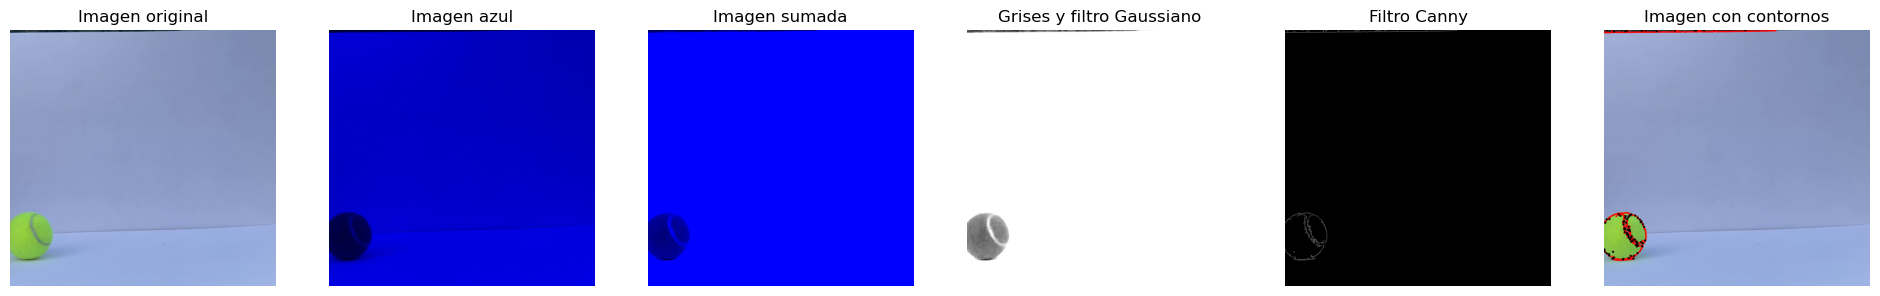

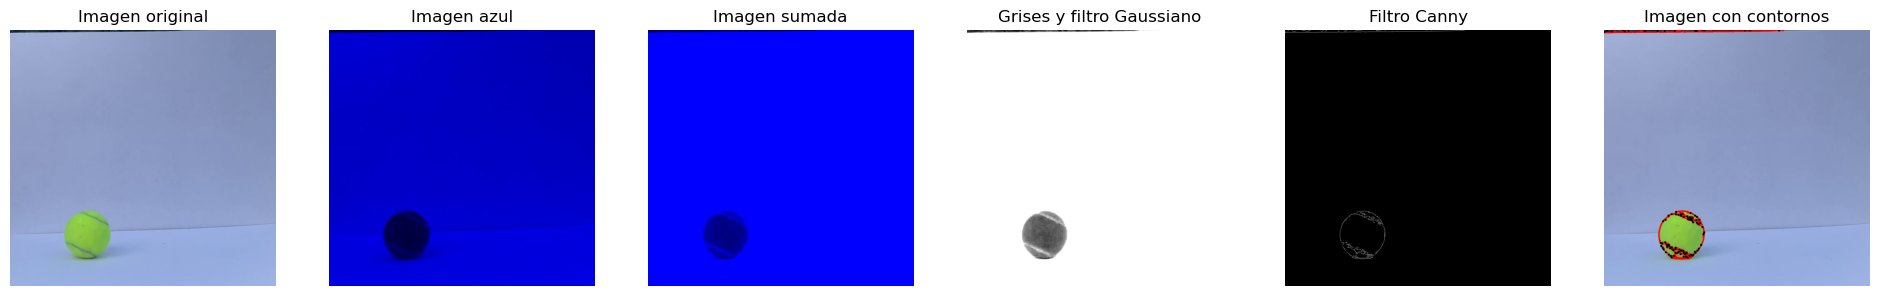

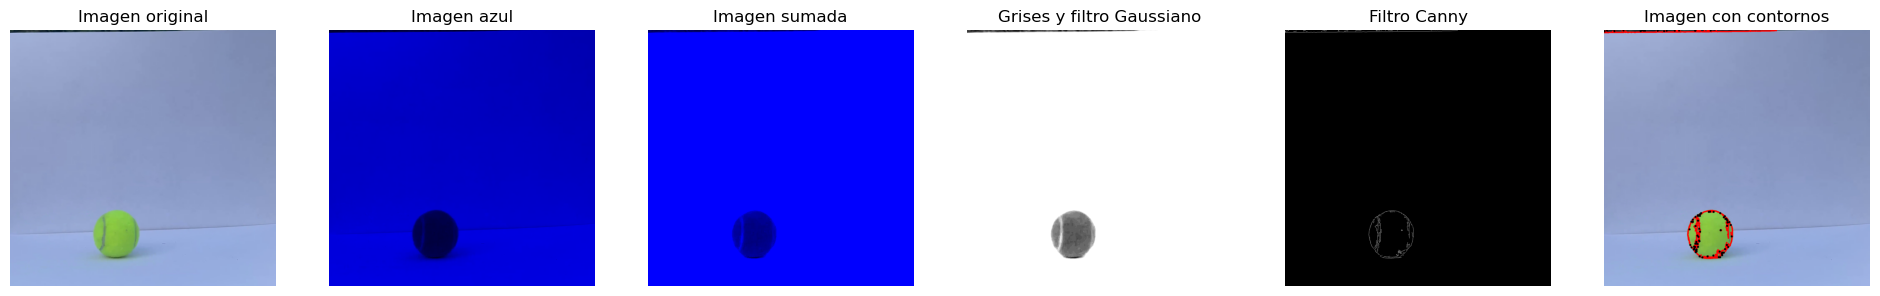

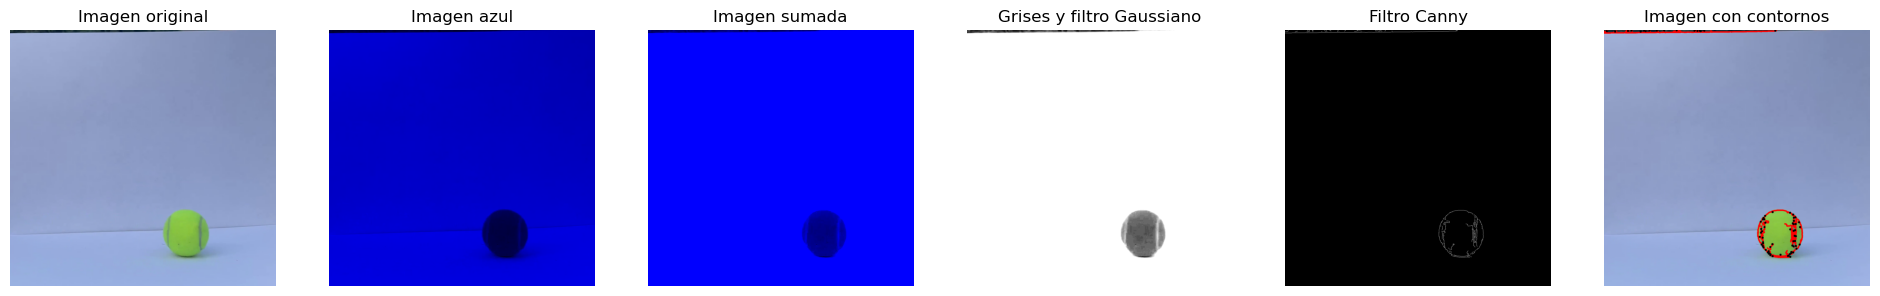

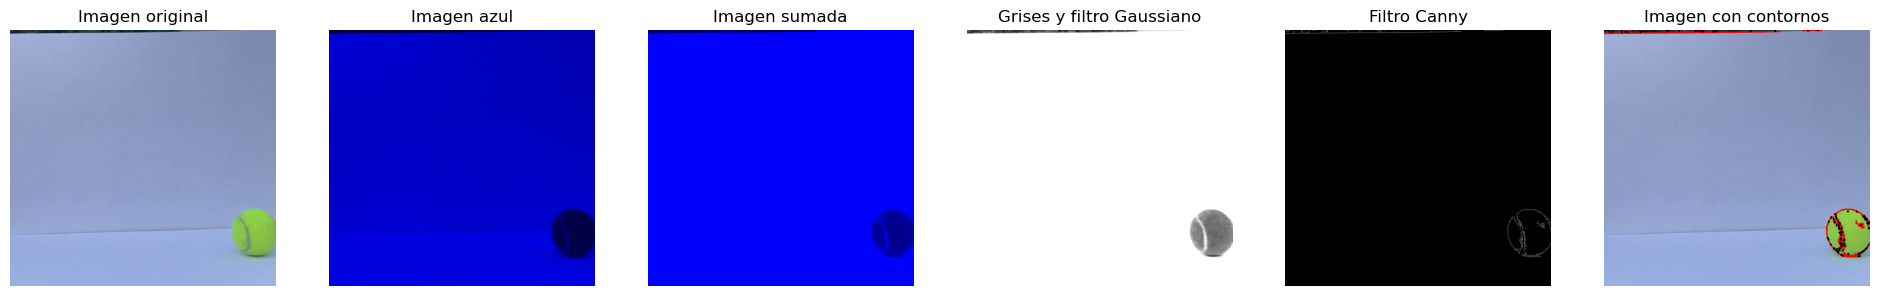

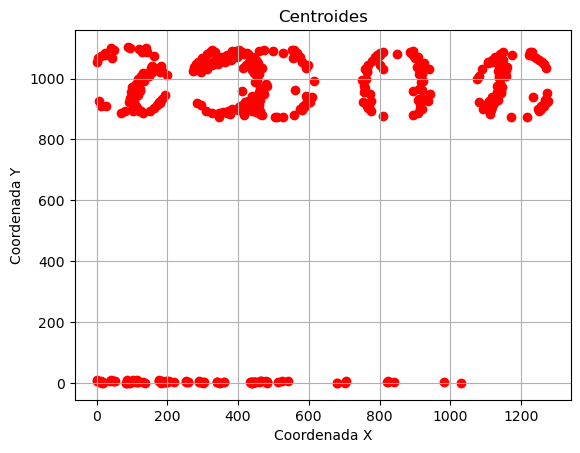

In [27]:
contornearGraficarPorCanny(muestraDesplazamiento)

### Desplazamiento con ruido:

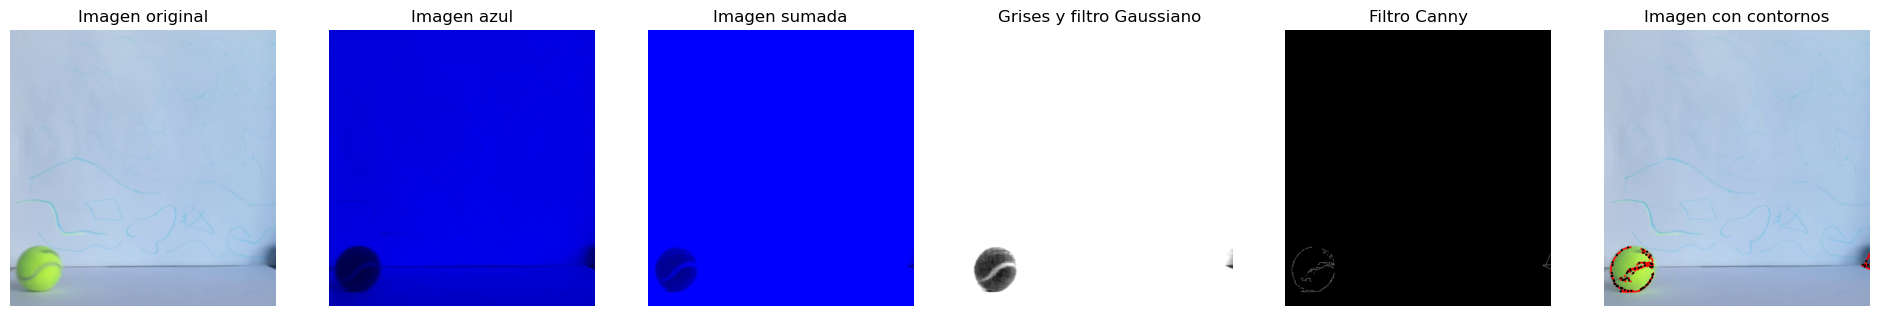

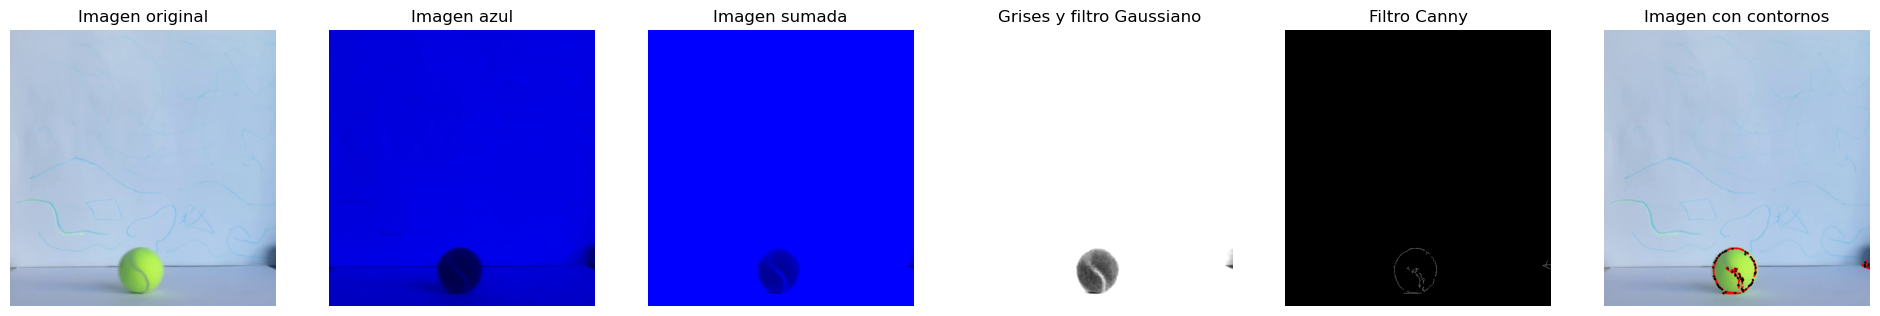

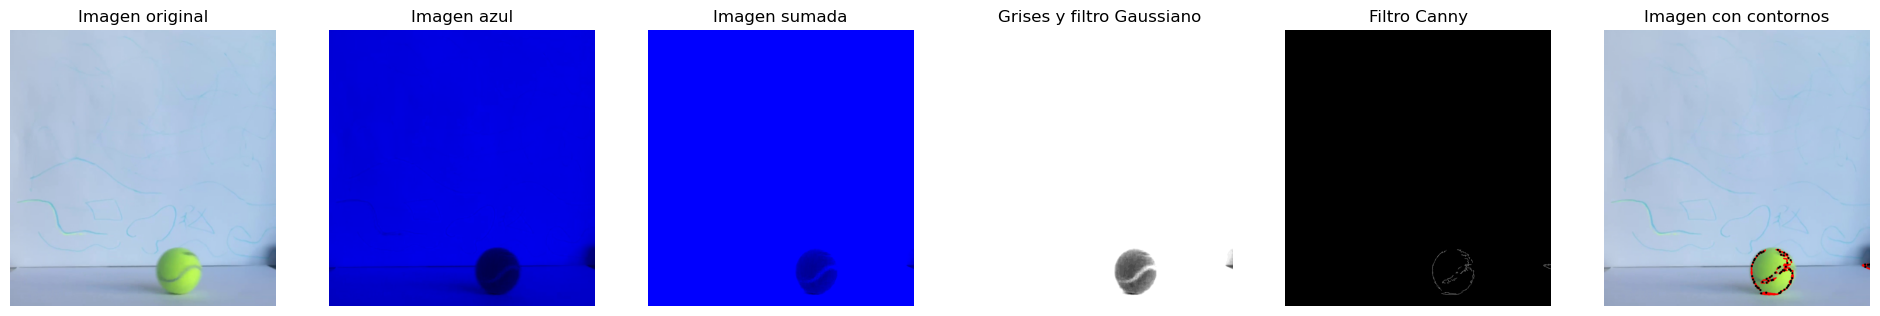

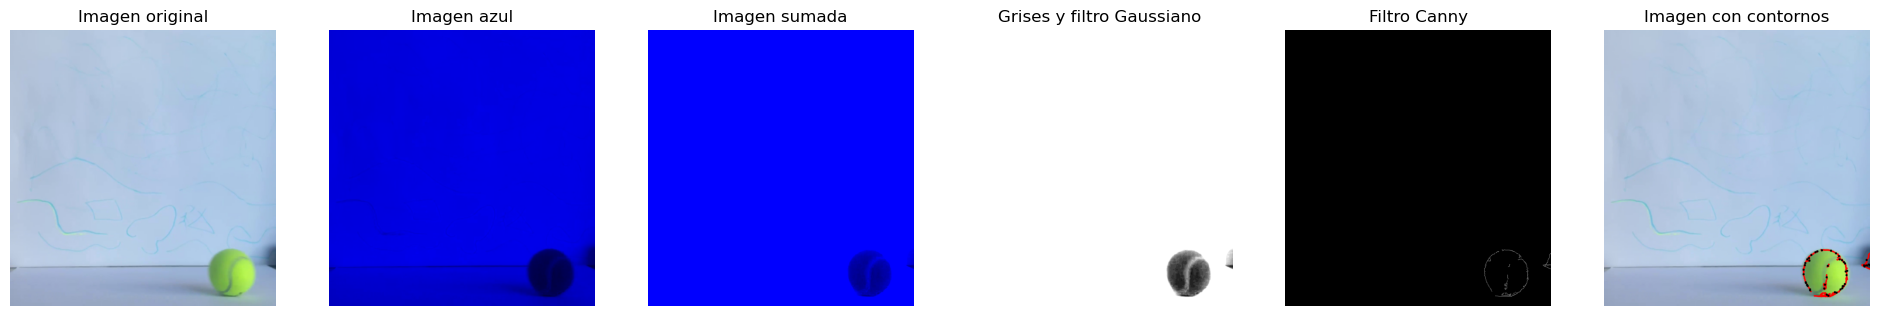

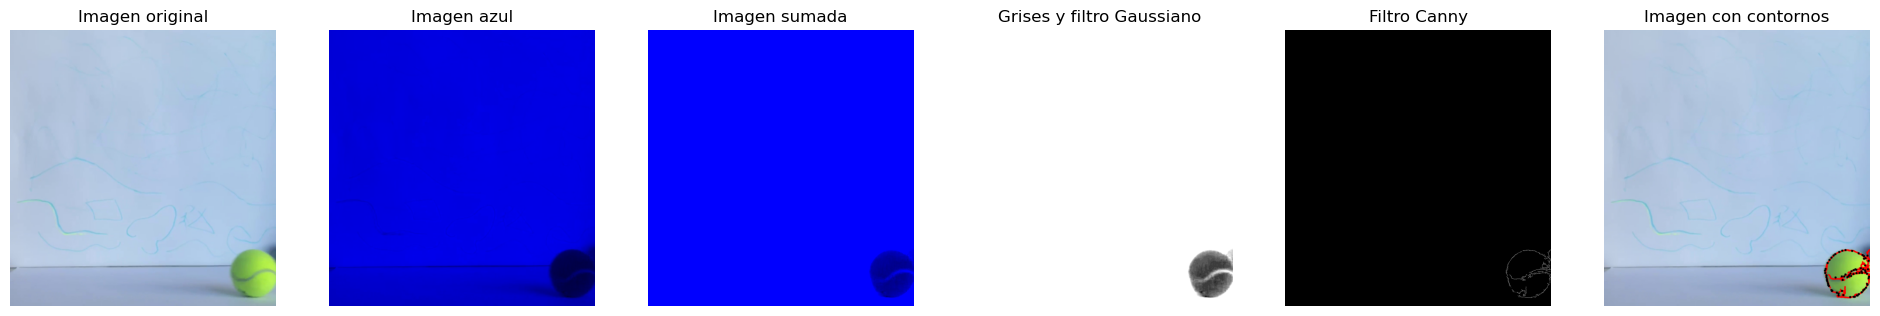

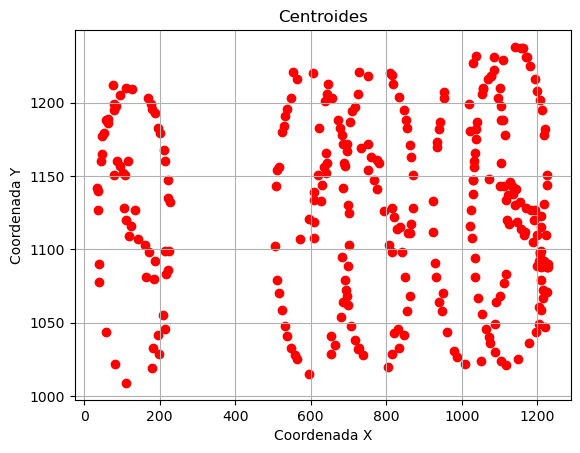

In [28]:
contornearGraficarPorCanny(muestraDesplazamientoRuido)

### Rebote sin ruido:

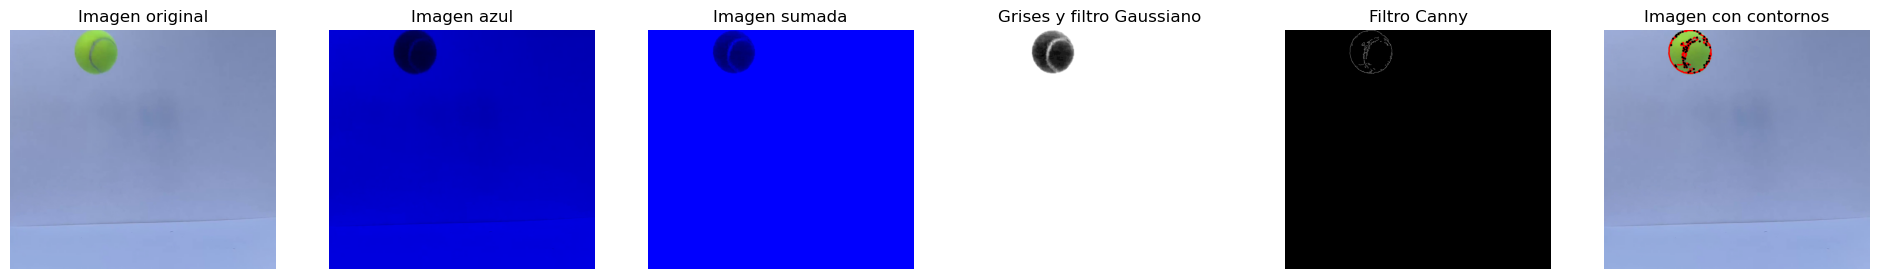

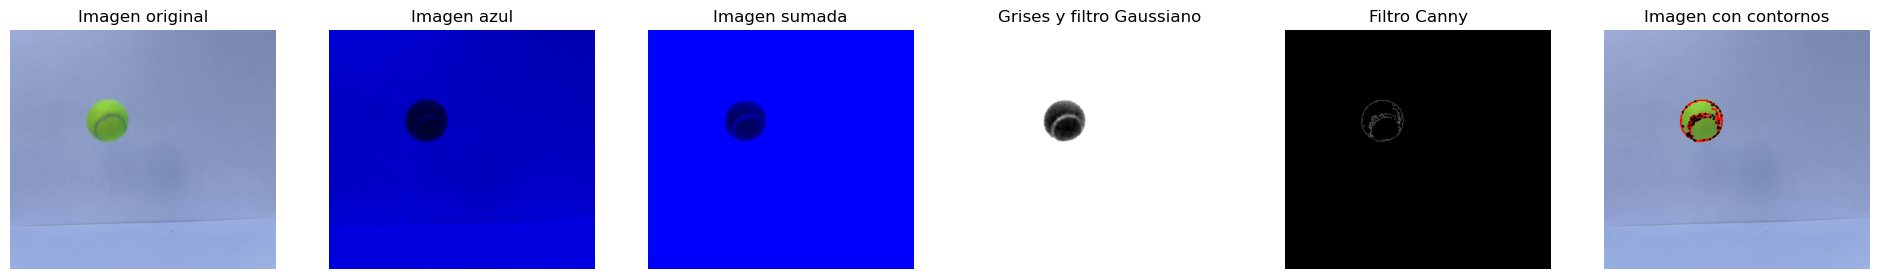

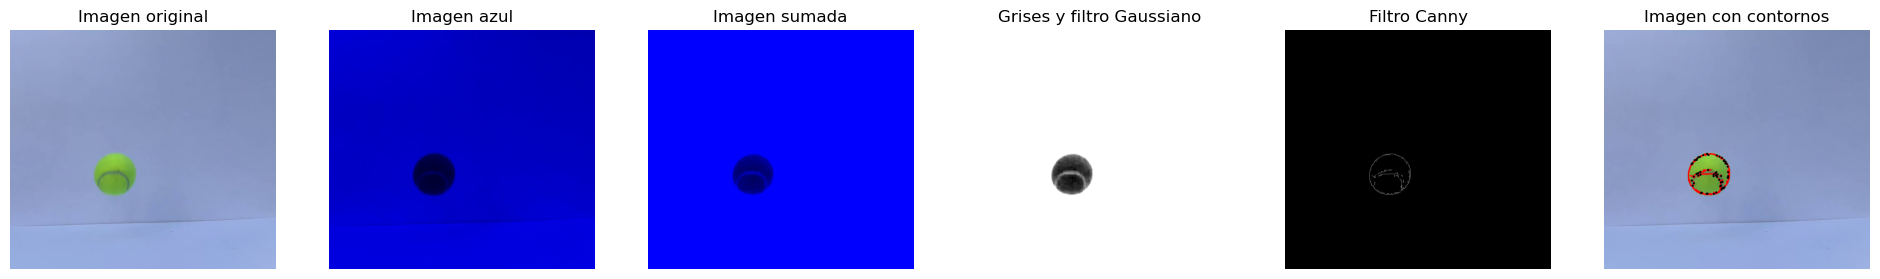

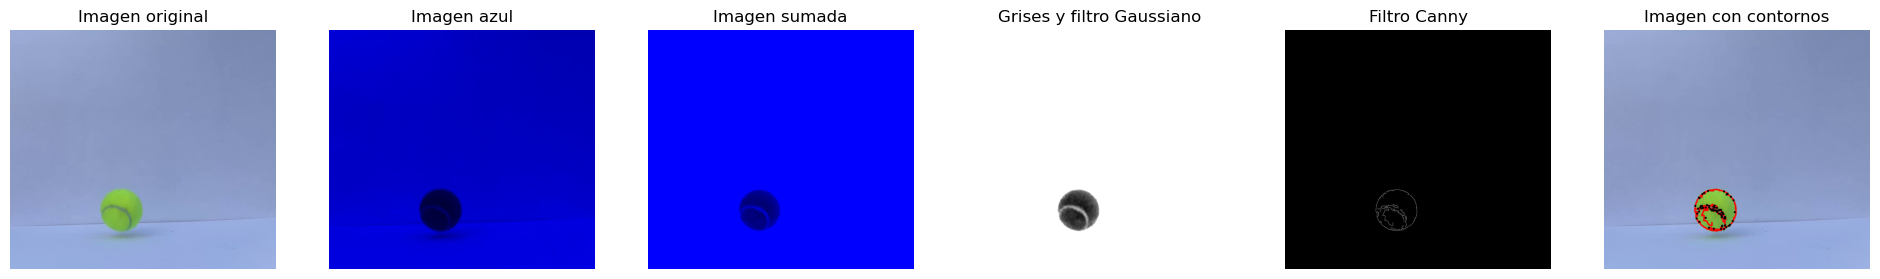

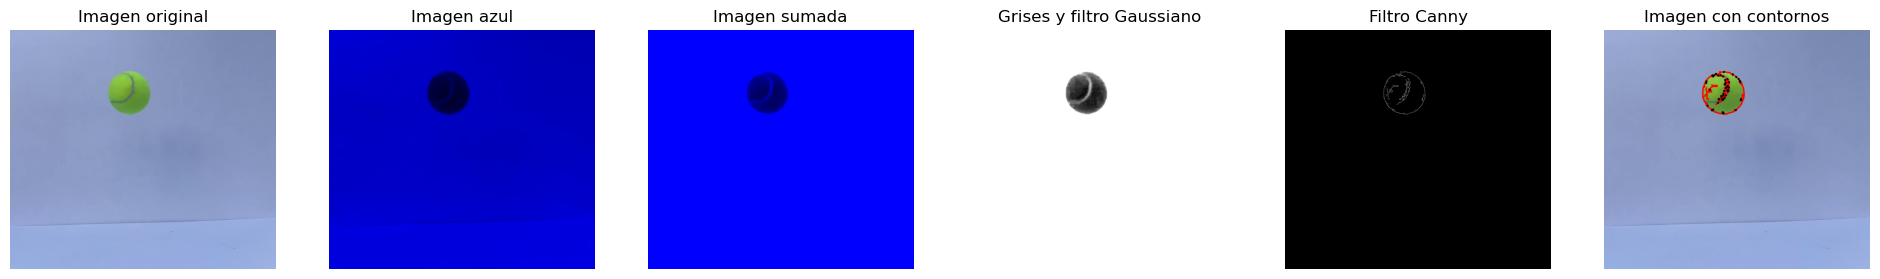

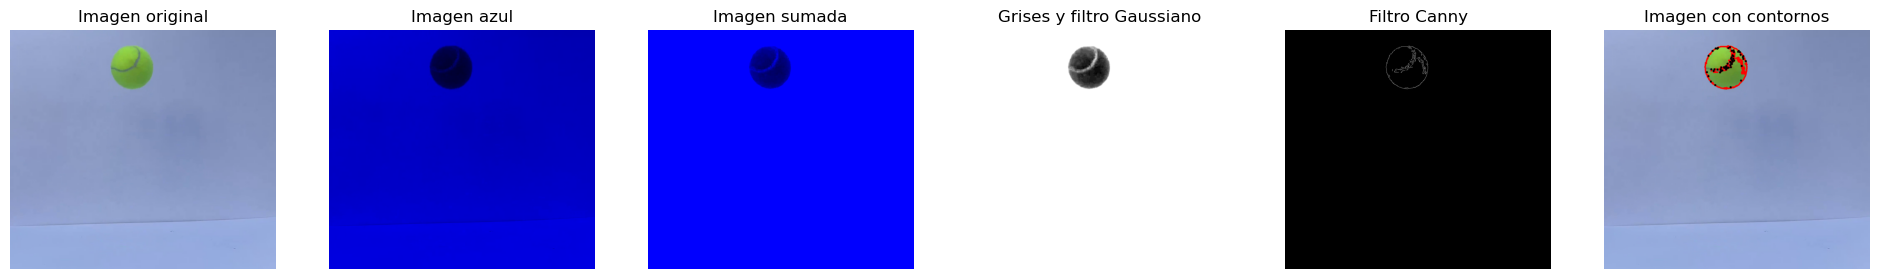

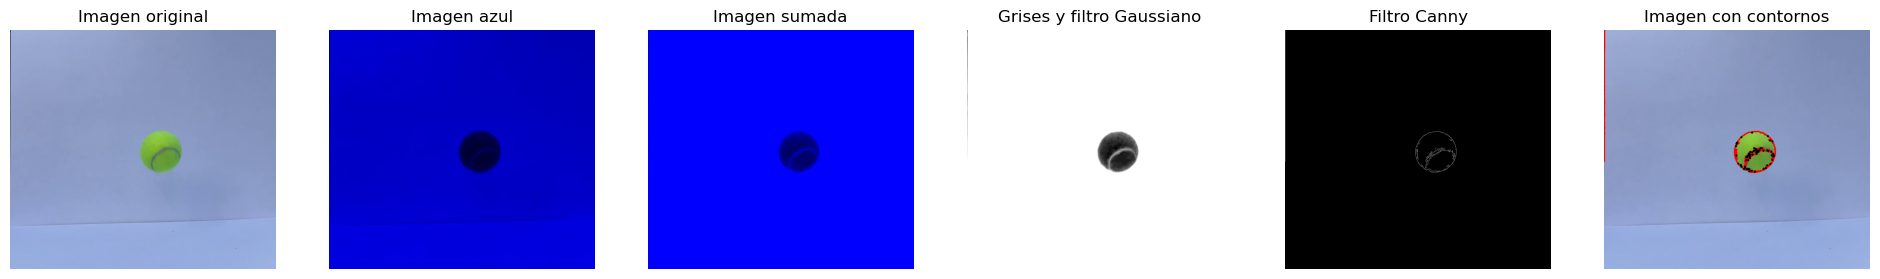

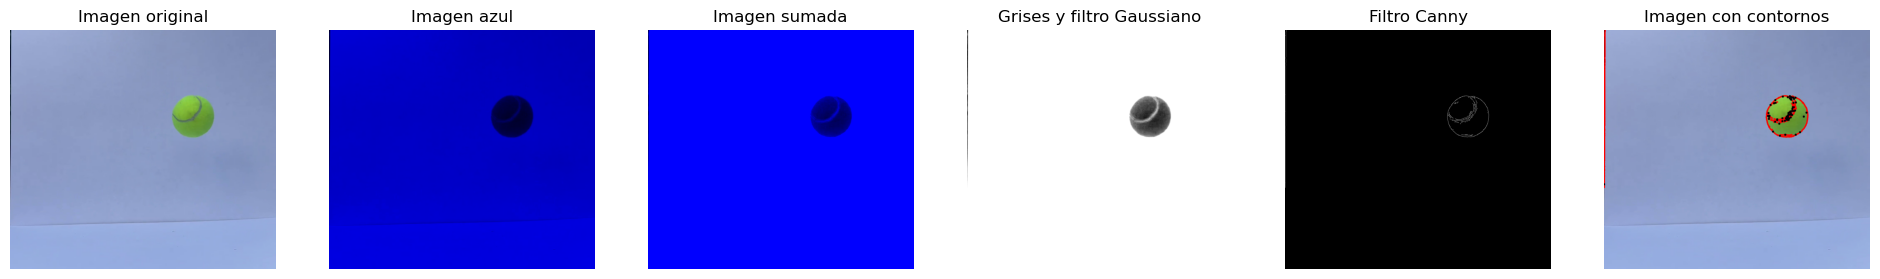

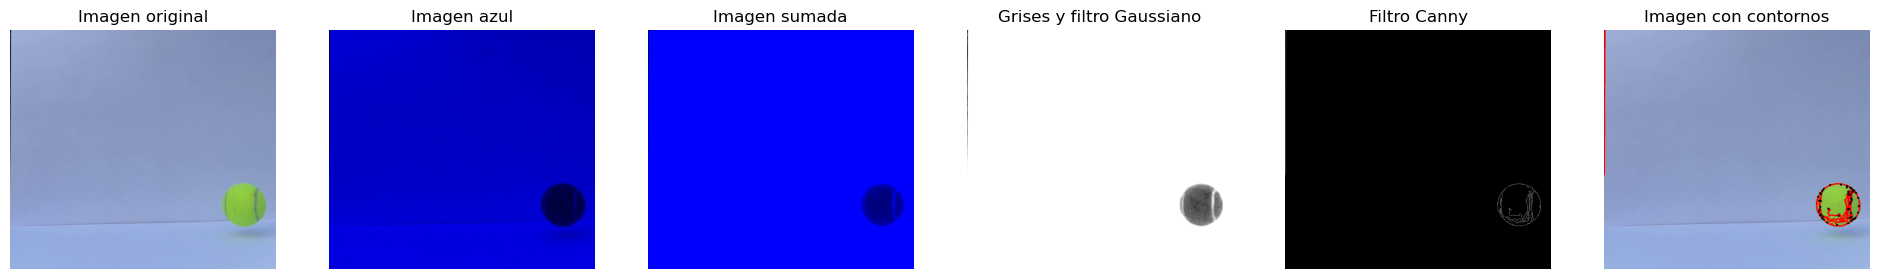

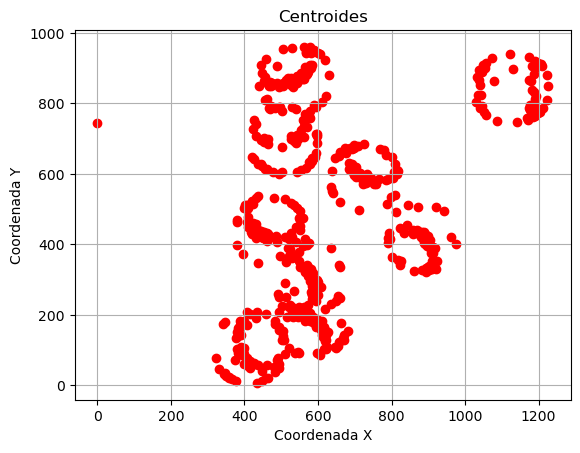

In [29]:
contornearGraficarPorCanny(muestraRebote)

### Rebote con ruido:

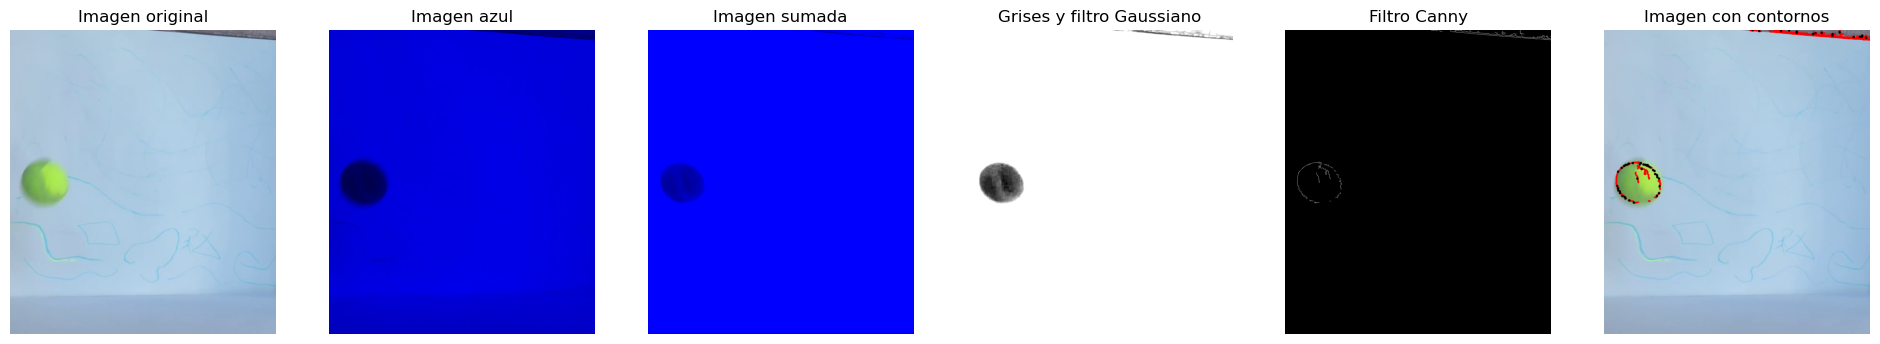

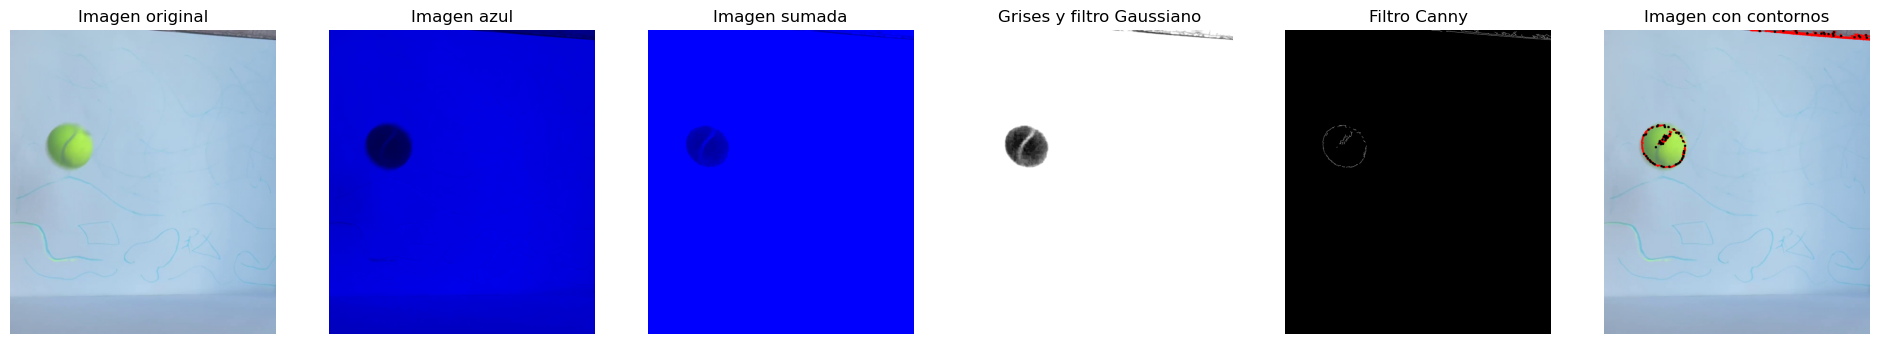

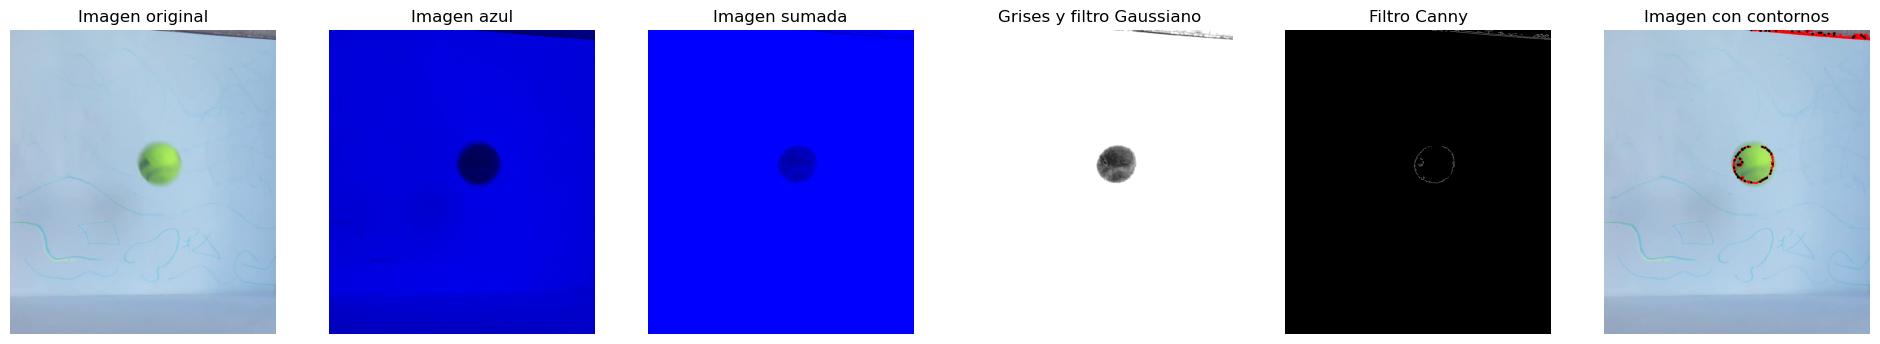

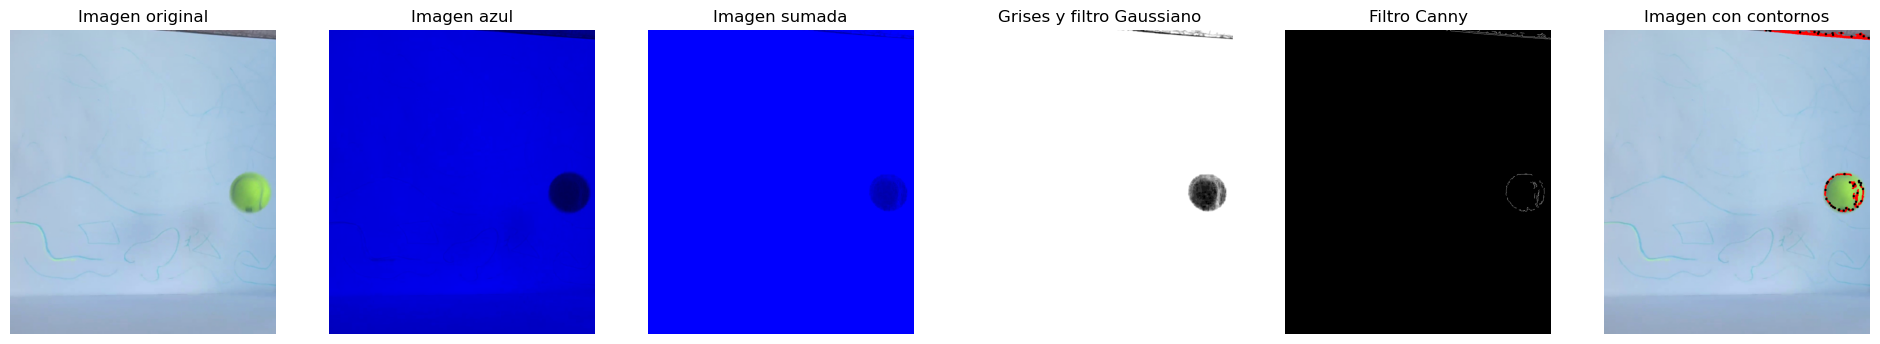

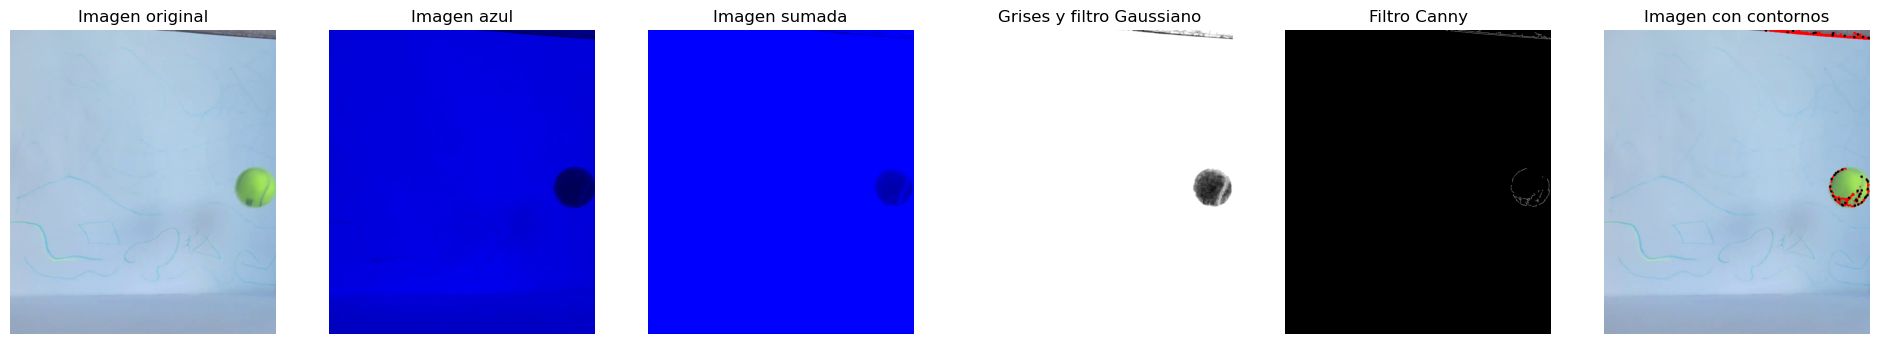

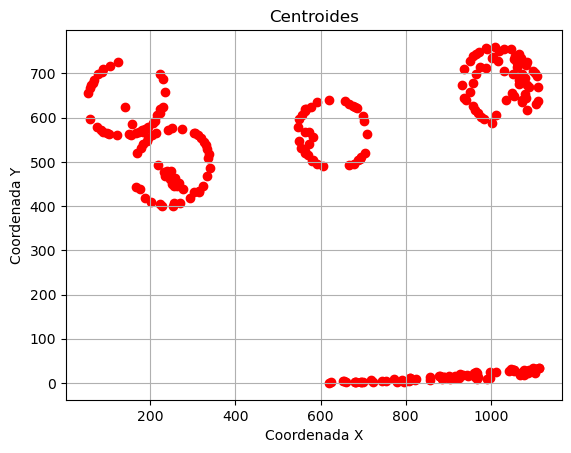

In [30]:
contornearGraficarPorCanny(muestraReboteRuido)

## Método 2 - Detección de bordes con operadores morfológicos y umbralización

#### Kernel:

In [31]:
def generarKernelCircular(tamaño_kernel=35):
    # Crear una matriz de ceros del tamaño especificado
    kernel_generado = np.zeros((tamaño_kernel, tamaño_kernel), dtype=np.uint8)

    # Calcular el centro del kernel
    centro_x, centro_y = tamaño_kernel // 2, tamaño_kernel // 2

    # Calcular el radio del círculo
    radio = tamaño_kernel // 2

    # Llenar la matriz con un círculo de unos
    for i in range(tamaño_kernel):
        for j in range(tamaño_kernel):
            if (i - centro_x) ** 2 + (j - centro_y) ** 2 <= radio ** 2:
                kernel_generado[i, j] = 1

    return kernel_generado

#### Función:

In [32]:
def contornearGraficarPorUmbralizacion(ruta_imagenes, imprimir=True, nombreGrafica = ""):
    centroides_x = []
    centroides_y = []

    for ruta_imagen in ruta_imagenes:
        imagen = cv2.imread(ruta_imagen)

        # 0. Extraer el canal azul de la imagen original y recortar el excedente de ruido, sin afectar la relación espacial.
        canal_azul = imagen[:, :, 0]  # El canal azul se encuentra en el primer canal (índice 0).
        imagen_azul = np.zeros_like(imagen)
        imagen_azul[:, :, 0] = canal_azul  # Colocar el canal azul en el canal azul de la nueva imagen.

        # 1. Convertir la imagen original a escala de grises.
        imagen_gris = cv2.cvtColor(imagen_azul, cv2.COLOR_BGR2GRAY)

        # 2. Aplicar algún filtro para mejorar la segmentación.
        imagen_filtrada = cv2.GaussianBlur(imagen_gris, (5, 5), 0)

        # 3. Realizar umbralización por rangos.
        imagen_umbralizada = cv2.inRange(imagen_filtrada, 0, 10)

        # 4. Aplicar dilatación para mejorar la calidad de los contornos.
        kernel = generarKernelCircular()
        imagen_dilatada = cv2.dilate(imagen_umbralizada, kernel, iterations=1)

        # 5. Obtener contornos y centroides de la imagen umbralizada.
        contornos, _ = cv2.findContours(imagen_dilatada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        imagen_contornos = imagen.copy()
        cv2.drawContours(imagen_contornos, contornos, -1, (0, 0, 255), 5) # Rojo.

        for contorno in contornos:
            momentos = cv2.moments(contorno)
            if momentos["m00"] != 0:
                centroide_x = int(momentos["m10"] / momentos["m00"])
                centroide_y = int(momentos["m01"] / momentos["m00"])
                centroides_x.append(centroide_x)
                centroides_y.append(centroide_y)
                cv2.circle(imagen_contornos, (centroide_x, centroide_y), 5, (0, 0, 0), -1)  # Puntos conectados (centroides) en color negro.

        imagen_rgb = cv2.cvtColor(imagen_contornos, cv2.COLOR_BGR2RGB)

        if imprimir:
            # Mostrar la imagen original, la imagen azul, el filtro Gaussiano, la imagen umbralizada y los contornos en subplots.
            fig, axes = plt.subplots(1, 6, figsize=(20, 6))
            
            axes[0].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB), cmap='gray')
            axes[0].set_title('Imagen original')
            axes[0].axis('off')
            
            axes[1].imshow(cv2.cvtColor(imagen_azul, cv2.COLOR_BGR2RGB), cmap='gray')
            axes[1].set_title('Imagen azul')
            axes[1].axis('off')

            axes[2].imshow(imagen_filtrada, cmap='gray')
            axes[2].set_title('Grises y filtro Gaussiano')
            axes[2].axis('off')

            axes[3].imshow(imagen_umbralizada, cmap='gray')
            axes[3].set_title('Umbralización')
            axes[3].axis('off')

            axes[4].imshow(imagen_dilatada, cmap='gray')  # Agregar imagen dilatada
            axes[4].set_title('Imagen dilatada')
            axes[4].axis('off')

            axes[5].imshow(imagen_rgb)
            axes[5].set_title('Imagen con contornos')
            axes[5].axis('off')

            plt.show()

    # Crear una gráfica para mostrar todos los centroides de todas las imágenes juntas.
    plt.scatter(centroides_x, centroides_y, c='r', marker='o', label='Centroides')
    plt.title('Centroides')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True)
    
    if imprimir == False:
             plt.savefig(f'./centroides/umbral/gráficaUmbral_{nombreGrafica}.png')
             plt.close() 
    elif imprimir:
            plt.show()

### Desplazamiento sin ruido:

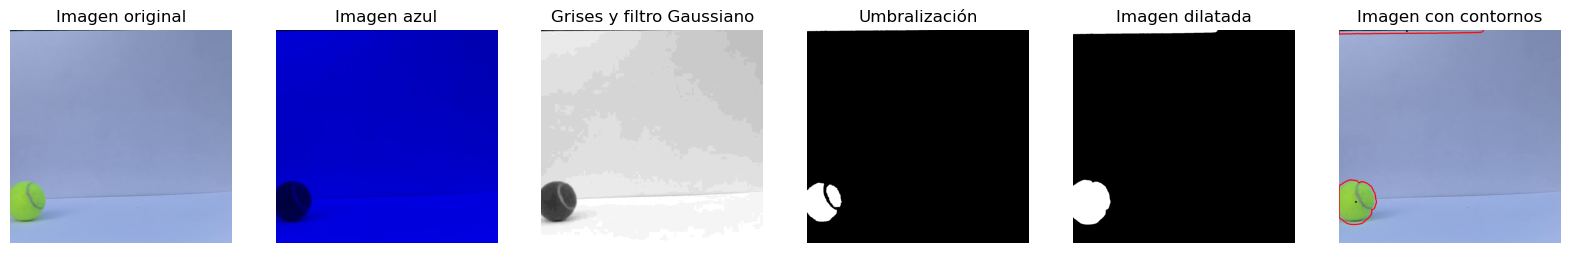

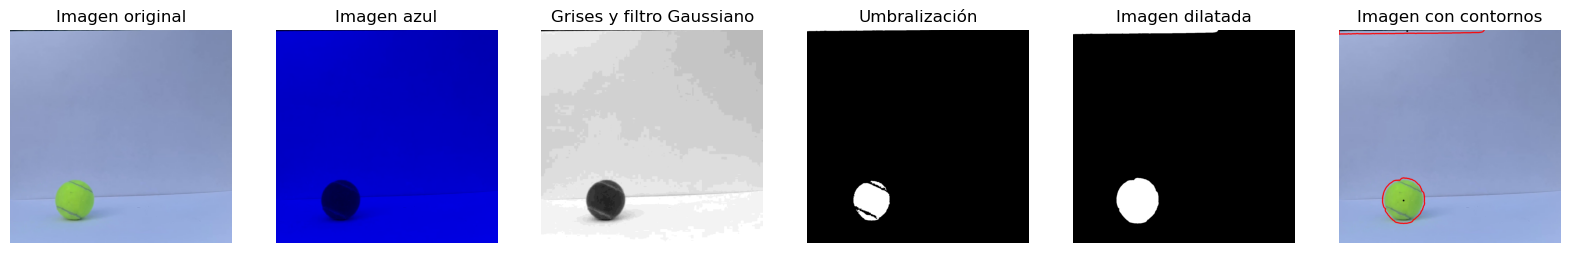

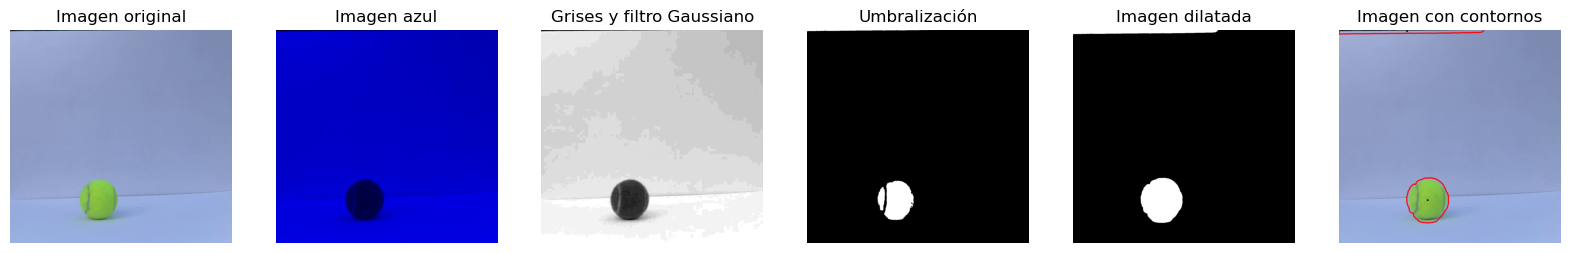

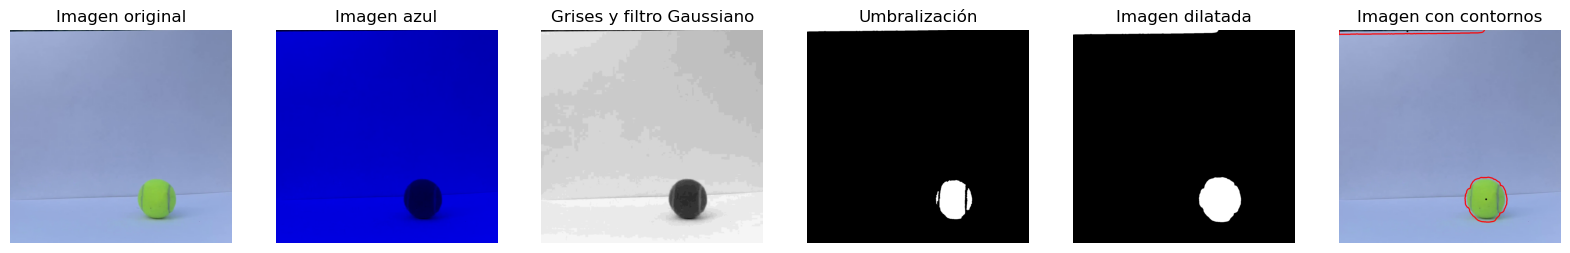

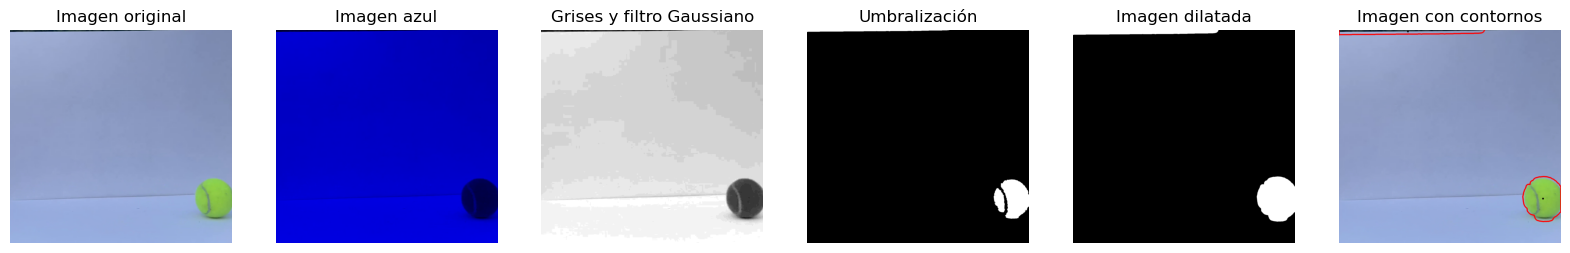

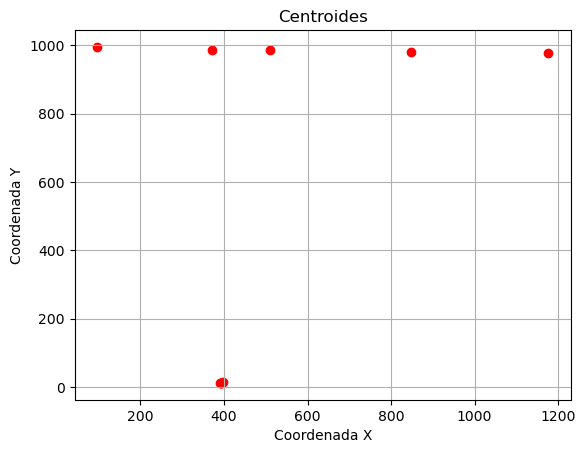

In [33]:
contornearGraficarPorUmbralizacion(muestraDesplazamiento)

### Desplazamiento con ruido:

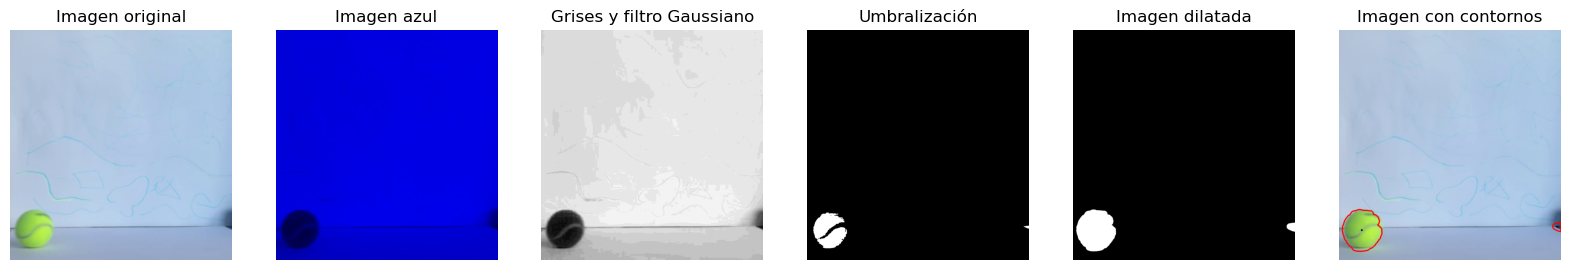

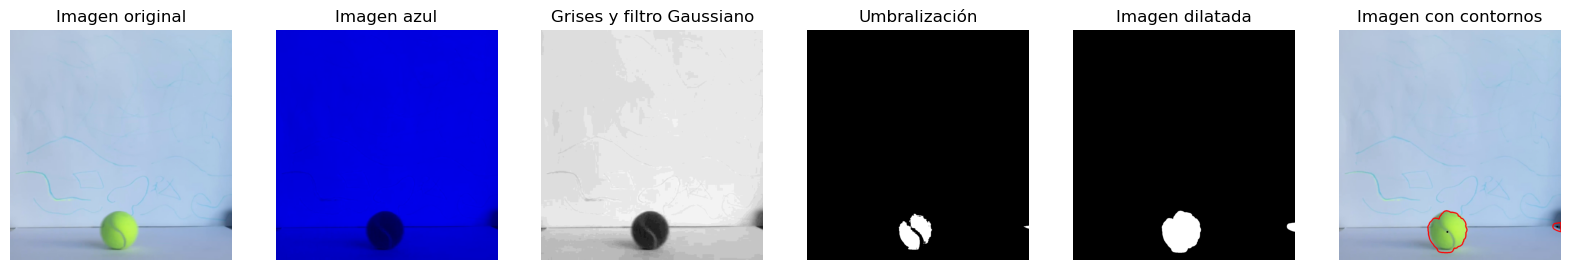

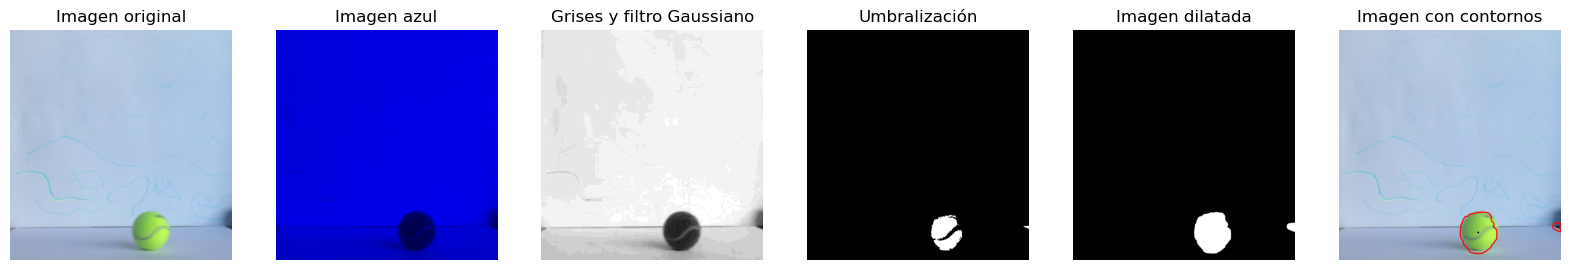

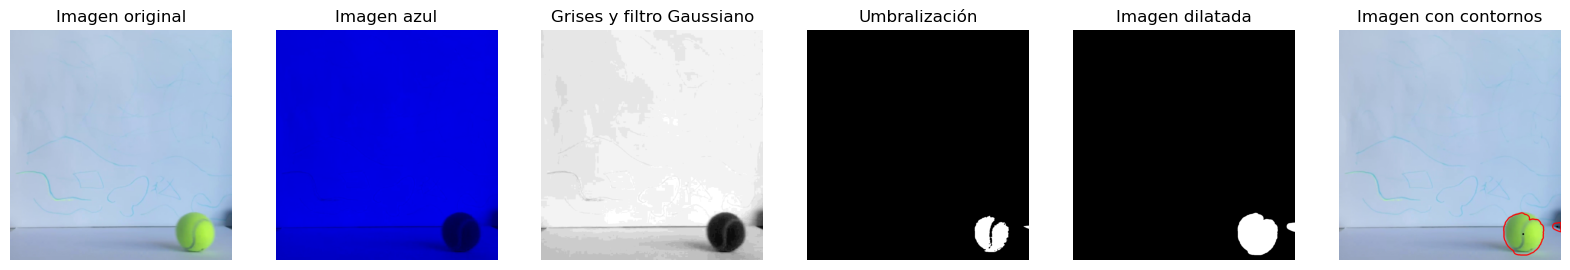

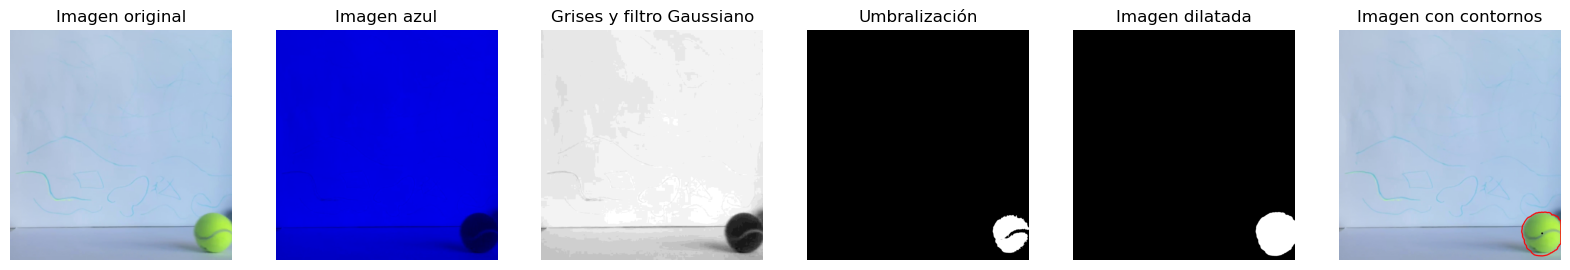

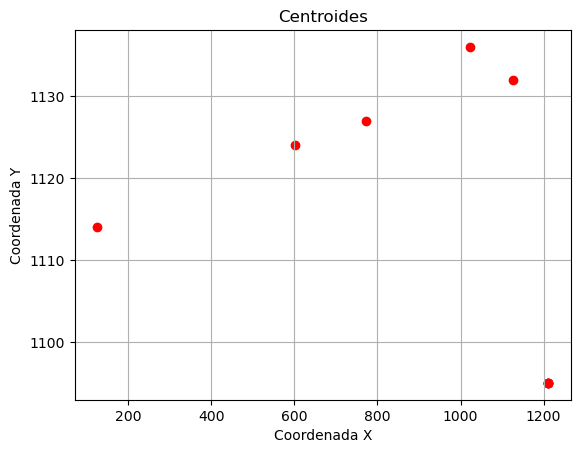

In [34]:
contornearGraficarPorUmbralizacion(muestraDesplazamientoRuido)

### Rebote sin ruido:

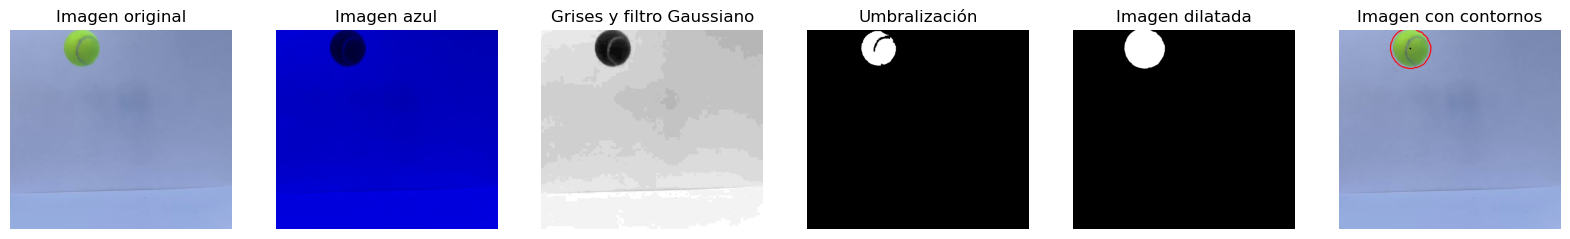

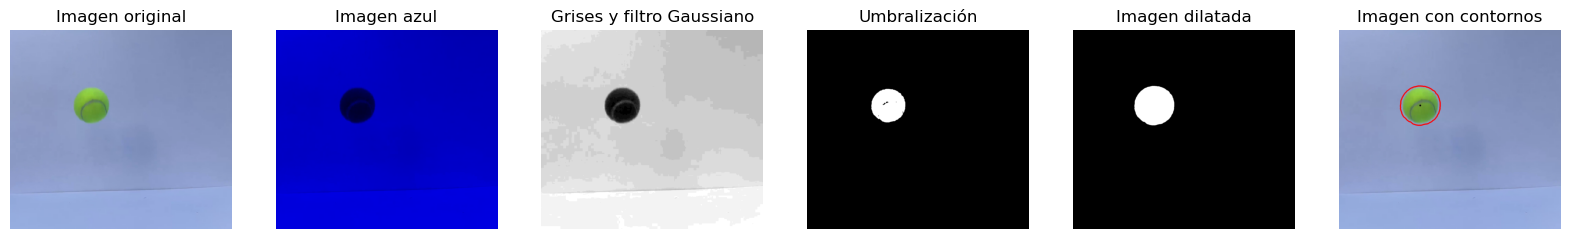

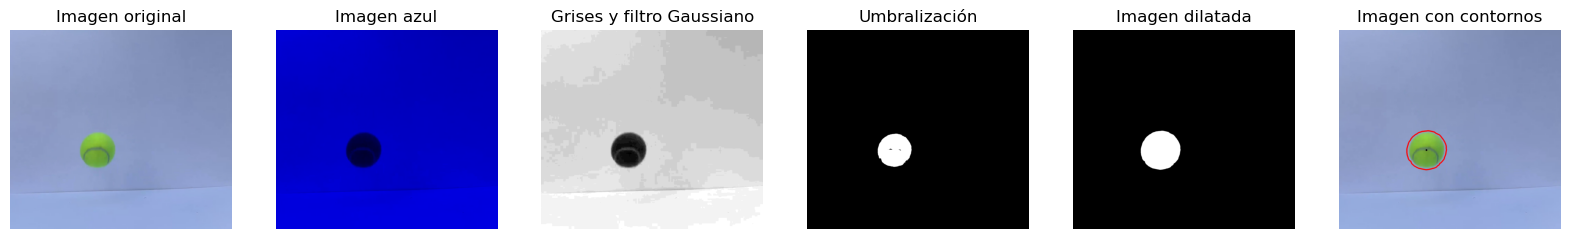

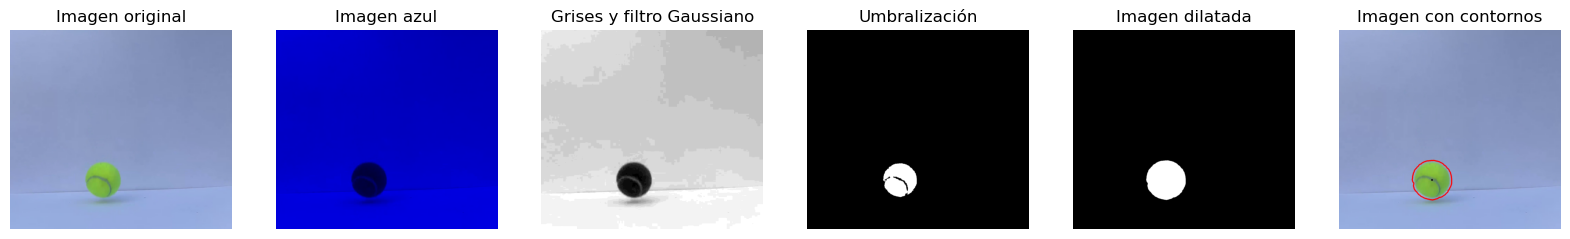

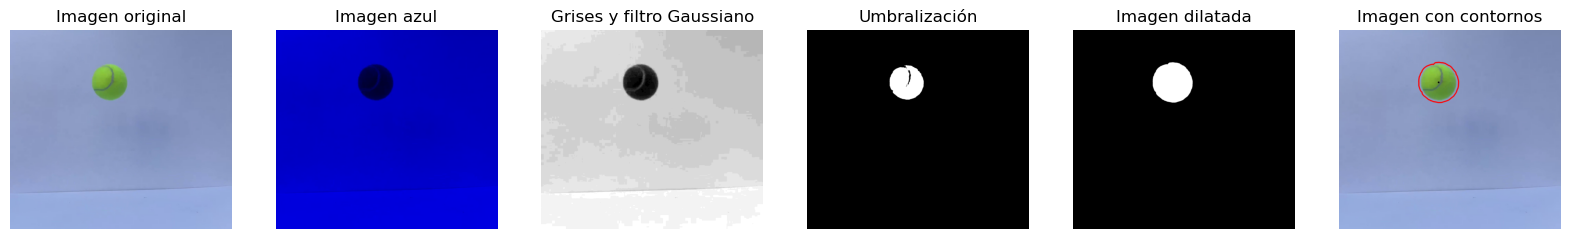

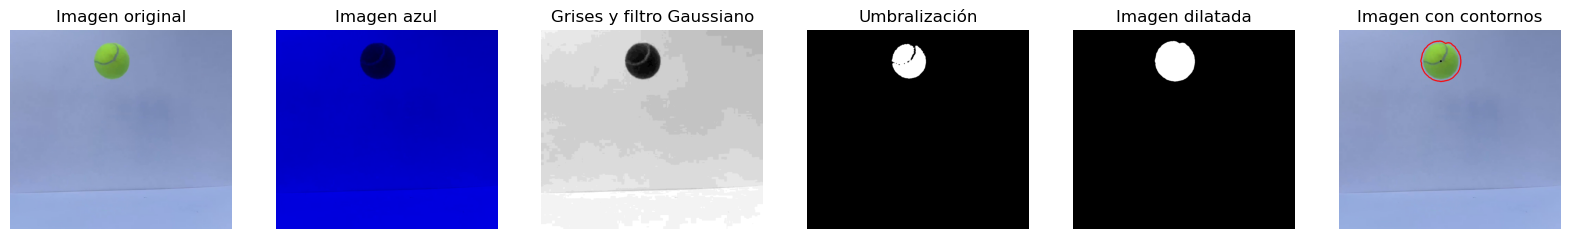

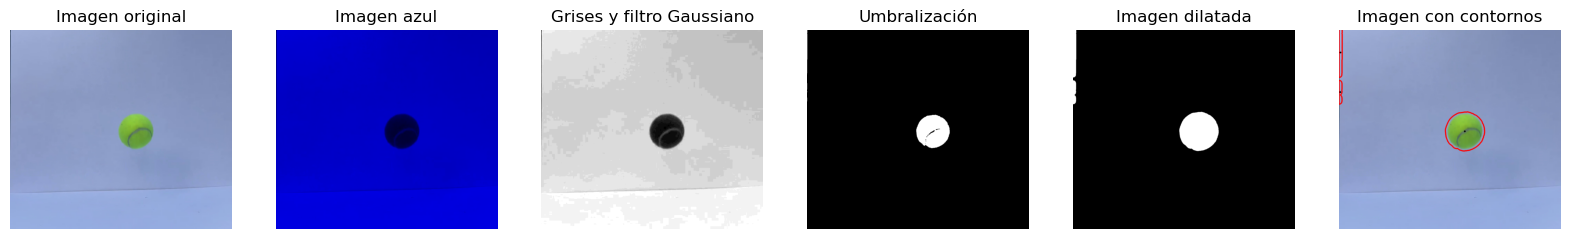

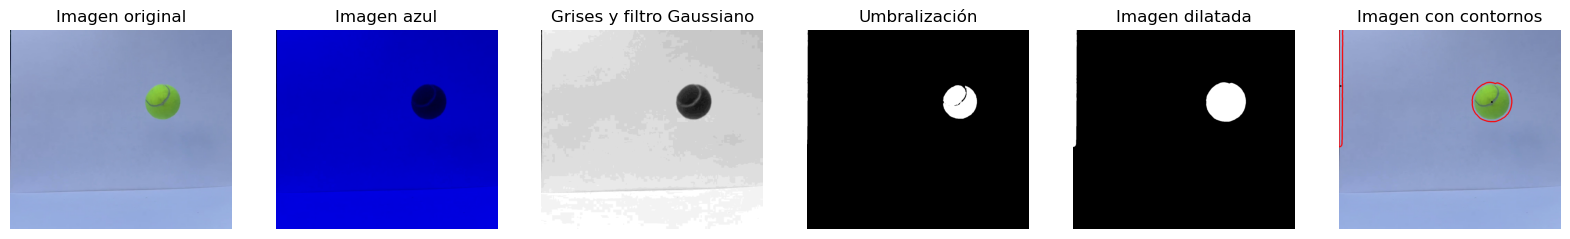

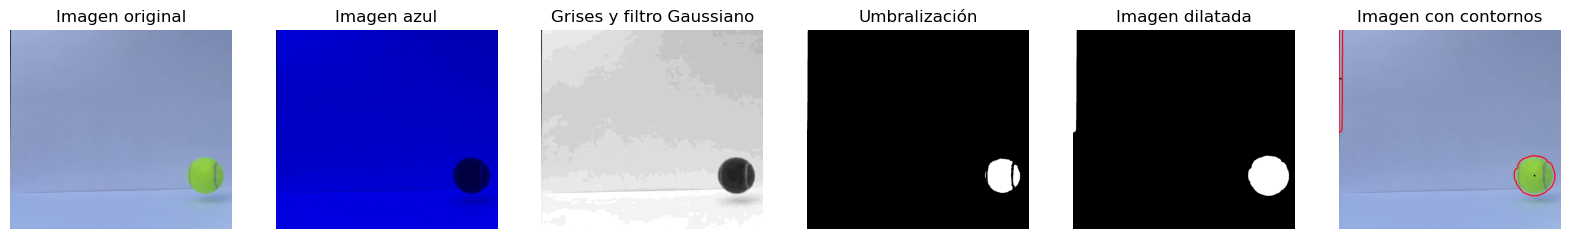

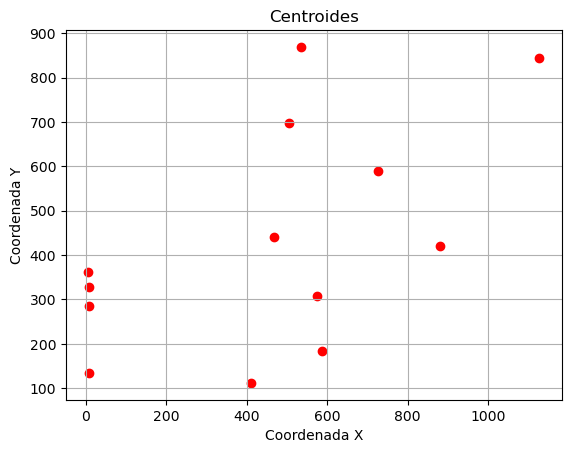

In [35]:
contornearGraficarPorUmbralizacion(muestraRebote)

### Rebote con ruido:

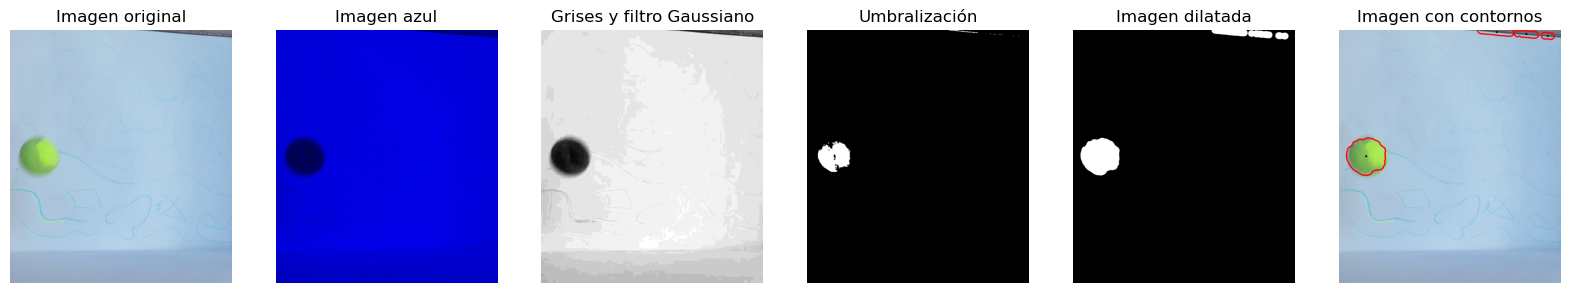

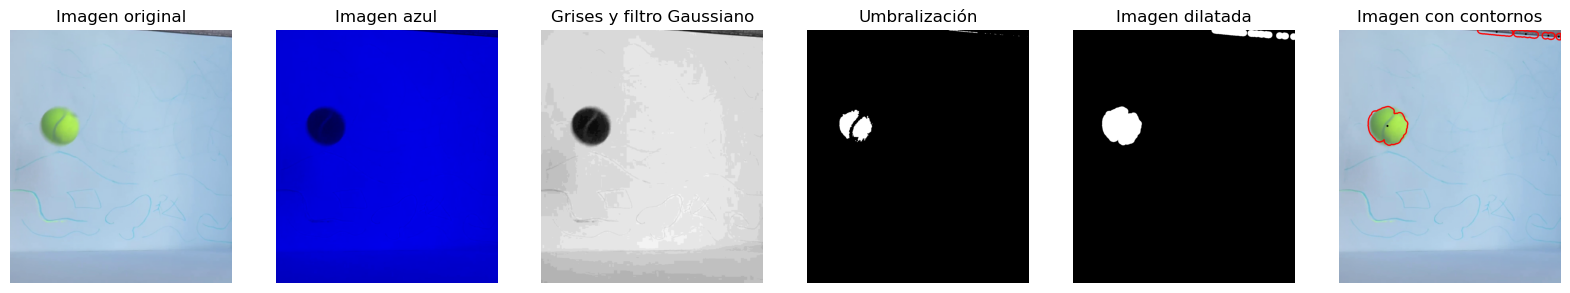

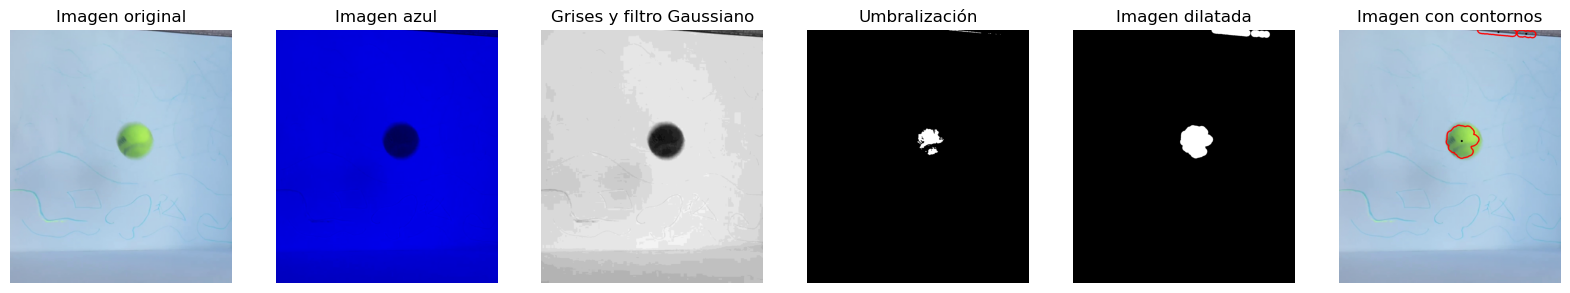

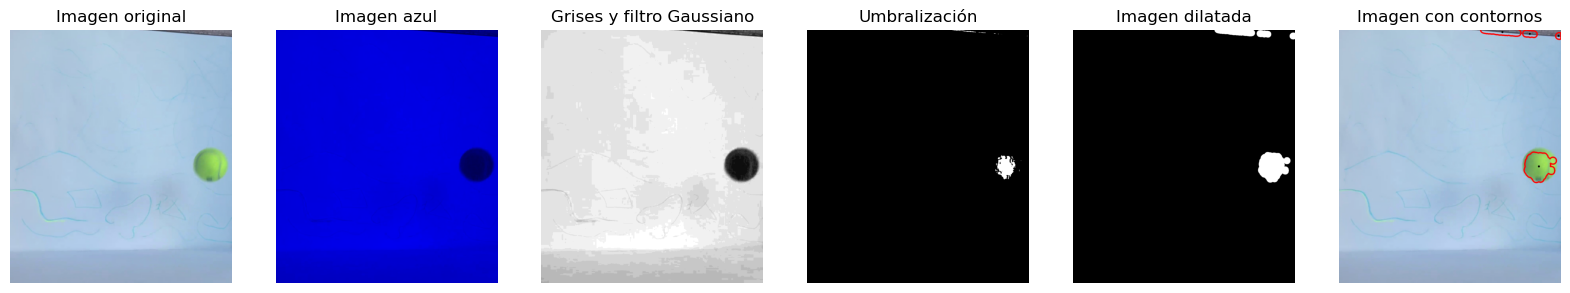

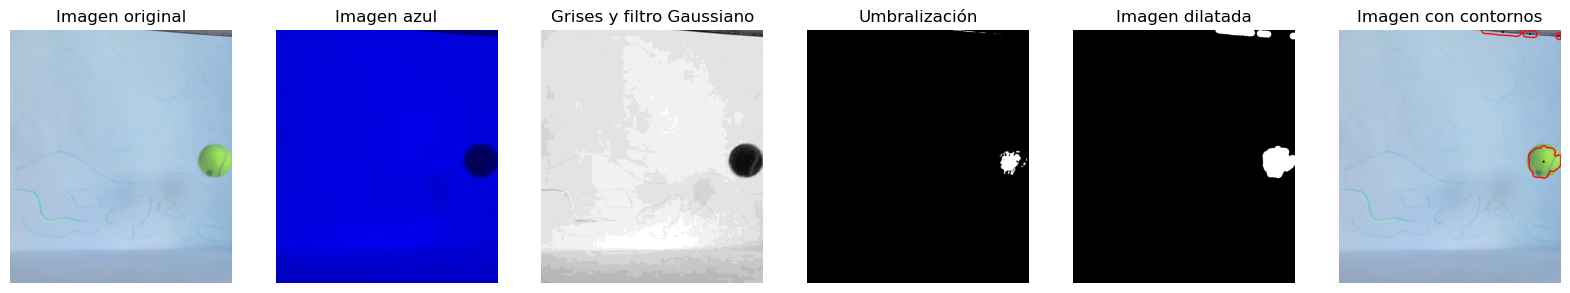

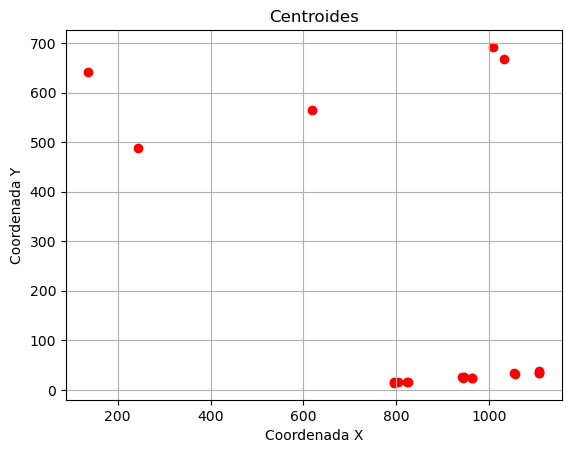

In [36]:
contornearGraficarPorUmbralizacion(muestraReboteRuido)

## Resultados de la trayectoria completa

### Procesar y contornear los centroides:

In [37]:
contornearGraficarPorCanny(framesDesplazamiento, False, "Desplazamiento")
contornearGraficarPorUmbralizacion(framesDesplazamiento, False, "Desplazamiento")
contornearGraficarPorCanny(framesDesplazamientoRuido, False, "DesplazamientoRuido")
contornearGraficarPorUmbralizacion(framesDesplazamientoRuido, False, "DesplazamientoRuido")
contornearGraficarPorCanny(framesRebote, False, "Rebote")
contornearGraficarPorUmbralizacion(framesRebote, False, "Rebote")
contornearGraficarPorCanny(framesReboteRuido, False, "ReboteRuido")
contornearGraficarPorUmbralizacion(framesReboteRuido, False, "ReboteRuido")

### Imprimir:

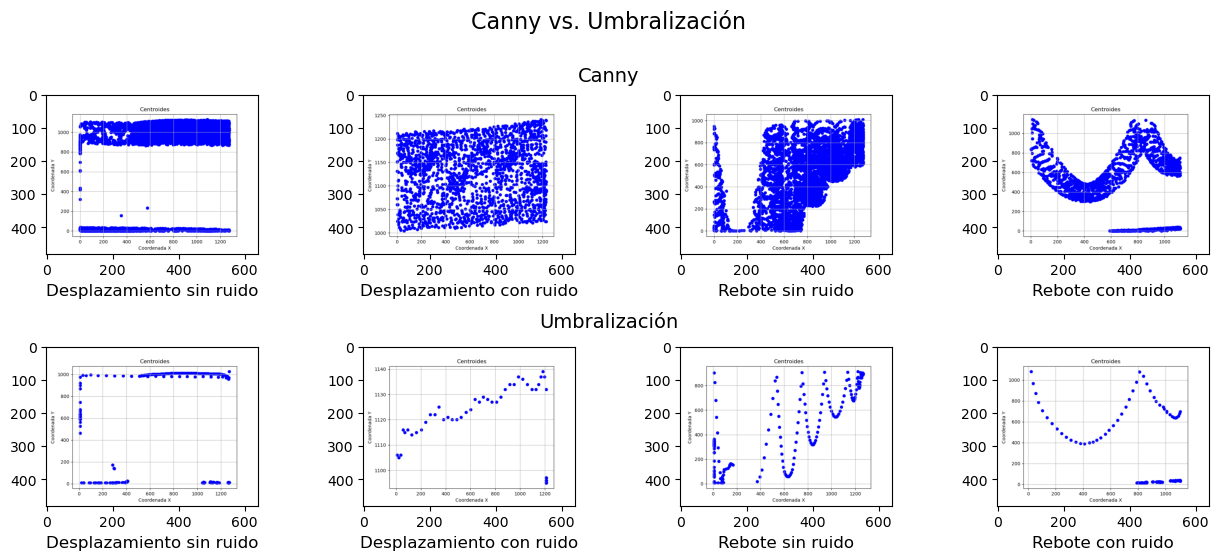

In [38]:
# Nombres de las categorías
categorias = ["Desplazamiento sin ruido", "Desplazamiento con ruido", "Rebote sin ruido", "Rebote con ruido"]

# Configurar la figura y los subplots
fig, axs = plt.subplots(2, len(graficasCanny), figsize=(15, 6))

# Títulos generales para Canny y Umbralización
fig.suptitle('Canny vs. Umbralización', fontsize=16)

for i, (canny_file, umbra_file, categoria) in enumerate(zip(graficasCanny, graficasUmbral, categorias)):
    # Leer las imágenes
    canny_img = cv2.imread(canny_file)
    umbra_img = cv2.imread(umbra_file) 
    
    # Mostrar las imágenes en los subplots
    axs[0, i].imshow(canny_img)
    axs[1, i].imshow(umbra_img)
    
    # Configurar subtítulos para cada conjunto de imágenes
    axs[0, i].set_xlabel(categoria, fontsize=12)
    axs[1, i].set_xlabel(categoria, fontsize=12)

# Añadir espacio entre los subplots
plt.subplots_adjust(wspace=0.5)

# Subtítulos generales para cada fila de gráficas
fig.text(0.5, 0.86, "Canny", ha="center", fontsize=14)
fig.text(0.5, 0.45, "Umbralización", ha="center", fontsize=14)

# Mostrar los subplots
plt.show()

### NOTA: Se hubieran obtenido mejores resultados si se recortaban las esquinas de la imagen (o se limpiaba anteriormente con Photoshop), al los bordes de la cartulina hacer ruido. Sin embargo, la diferencia de efectividad por método de procesamiento, además de adquisición; es bastante. Añadido a ello, esto aporta reflexión a las conclusiones y aborda los límites del procesamiento.